In [1]:
# from ex_bnnstgp import BNN_model
import pandas as pd
import h5py
import numpy as np
import torch
import os
import sys
import random
# current_dir = os.getcwd()
# sub_dir = os.path.join(current_dir, 'packaging2/pkg_bnnstgp2') 
# sys.path.append(sub_dir)
# from pkg_bnnstgp import BNN_model
import os
os.environ['R_HOME'] = '/home/ellahe/.conda/envs/bnnstgp/lib/R'
from pkg_bnnstgp2.pkg_bnnstgp import BNN_model
from sklearn.metrics import r2_score


# import rpy2.robjects as robjects


from rpy2.robjects.packages import importr

utils = importr('utils')
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import time
import random
import pandas as pd
# import rpy2.robjects as robjects
import numpy as np
# from rpy2.robjects import pandas2ri
# readRDS = robjects.r['readRDS']
import h5py


# %matplotlib inline

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim.optimizer import Optimizer, required
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from tqdm.notebook import tqdm
from tqdm import tqdm
import SimpleITK as sitk
import nibabel as nib
import scipy.stats
from scipy.stats import invgamma
import math

import warnings
warnings.filterwarnings("ignore")

print("Start")
if torch.cuda.is_available():
    print('using GPU')
else:
    print('using CPU')
    
import os
os.environ['R_HOME'] = '/home/ellahe/.conda/envs/bnnstgp/lib/R'

import rpy2.robjects as robjects

from rpy2.robjects.packages import importr


utils = importr('utils')

# options(repos=c('https://repo.miserver.it.umich.edu/cran/'))
# utils.install_packages('BayesGPfit', verbose = 0,repos = 'https://repo.miserver.it.umich.edu/cran/')
GP = importr('BayesGPfit')


# options(repos=c('https://repo.miserver.it.umich.edu/cran/'))
# utils.install_packages('BayesGPfit', verbose = 0,repos = 'https://repo.miserver.it.umich.edu/cran/')
# GP = importr('BayesGPfit')


# Y = pd.read_csv("y1.csv").iloc[:,1].values
# idx = np.invert(np.isnan(Y))
# Y = Y[idx]

# hf = h5py.File('/scratch/jiankang_root/jiankang1/ellahe/image1.hdf5', 'r')
# img1 = hf.get('img')['img1'][()][idx,:]
# # img2 = hf.get('img')['img2'][()][idx,:]

# h2 = h5py.File('/scratch/jiankang_root/jiankang1/ellahe/coord1.hdf5', 'r')
# hf = h5py.File('/scratch/jiankang_root/jiankang1/ellahe/image_fMRI2.hdf5', 'r')
# img2 = hf.get('img')['img_fMRI'][()][idx,:]

# h2 = h5py.File('/scratch/jiankang_root/jiankang1/ellahe/coord_fMRI2.hdf5', 'r')
# img_data = [img1, img2]

Start
using CPU
Start
using CPU


45.88287310609636
263.18633237748537


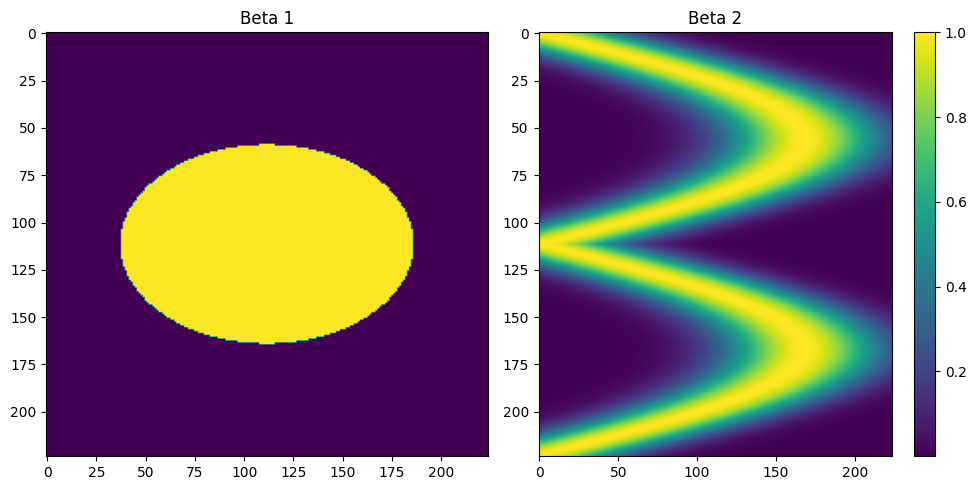

In [24]:
def compute_bases(v_list,poly_degree=30,a=0.001,b=20):
    Psi = GP.GP_eigen_funcs_fast(v_list, poly_degree = poly_degree, a = a, b = b)
    lam = GP.GP_eigen_value(poly_degree = poly_degree, a = a, b = b, d = np.array(v_list).shape[1])
    lam=list(lam)
    sqrt_lambda = list(np.sqrt(lam))
    Psi2 = np.transpose(np.array(Psi))
    Bases = np.zeros((Psi2.shape[0],Psi2.shape[1]))
    for i in range(len(sqrt_lambda)):
        Bases[i,:] = Psi2[i,:]*sqrt_lambda[i]
    
    return Bases
    

def simulate_data(r, random_seed=2023):
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    v_list1 = GP.GP_generate_grids(d = 2, num_grids = 224,grids_lim=np.array([-3,3]))
    v_list2 = GP.GP_generate_grids(d = 2, num_grids = 224,grids_lim=np.array([-1,1]))
    true_beta1 = (0.5*v_list1[:,0]**2+v_list1[:,1]**2)<2
    true_beta2 = np.exp(-5*(v_list2[:,0]-1.5*np.sin(math.pi*np.abs(v_list2[:,1]))+1.0)**2)
    p1 = v_list1.shape[0]
    p2 = v_list2.shape[0]
    m = 1000

    Bases1 = compute_bases(v_list1)
    Bases2 = compute_bases(v_list2)
    theta1 = np.random.normal(size=m*Bases1.shape[0],scale=1/np.sqrt(p1))
    theta1 = theta1.reshape(Bases1.shape[0],m)
    theta2 = np.random.normal(size=m*Bases2.shape[0],scale=1/np.sqrt(p2))
    theta2 = theta2.reshape(Bases2.shape[0],m)
    # simulate an image
    img1 = np.transpose(np.dot(np.transpose(Bases1),theta1))
    img2 = np.transpose(np.dot(np.transpose(Bases2),theta2))
    v_list1 = np.array(v_list1)
    v_list2 = np.array(v_list2)
    
    R2 = r
    # variance of sigma^2
    theta0 =  2
    mean_Y = theta0 + np.dot(img1,true_beta1) + np.dot(img2,true_beta2)
    # mean_Y = theta0 + np.dot(img2,true_beta2)
    print(np.var(np.dot(img1,true_beta1)))
    print(np.var(np.dot(img2,true_beta2)))
    true_sigma2 = np.var(mean_Y)*(1-R2)/R2
    Y = mean_Y + np.random.normal(size=m,scale=np.sqrt(true_sigma2))
    v_list = [v_list1,v_list2]
    img = [img1, img2]
    
    # plt.imshow(true_beta1.reshape(30,30))
    # plt.show
    # plt.imshow(true_beta2.reshape(20,20))
    # plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # plot true_beta1
    axs[0].imshow(true_beta1.reshape(224,224), aspect='auto')
    axs[0].set_title("Beta 1")

    # plot true_beta2
    cax = axs[1].imshow(true_beta2.reshape(224,224), aspect='auto')
    axs[1].set_title("Beta 2")

    # Add a colorbar to true_beta2 plot
    fig.colorbar(cax, ax=axs[1])

    # Show the plot
    plt.tight_layout()
    plt.show()
    # fig.savefig("simulation_data/simulated_data.pdf", format='pdf') 

    return v_list, img, Y

r = 0.9
coord, img_data, Y = simulate_data(r)
img1 = img_data[0]
img2 = img_data[1]

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming img1 and img2 are your image data matrices and Y is your target variable
# Concatenate the image features
X_combined = np.hstack([img1, img2])

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_combined)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_standardized, Y, test_size=0.2, random_state=42)

# Initialize the ElasticNet model
elastic_net = ElasticNet(random_state=42)

# Fit the model
elastic_net.fit(X_train, Y_train)

# Predict on the test set
Y_pred = elastic_net.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 44.725908860581164


In [20]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(Y_test, Y_pred)
print(f"R^2 Score: {r2}")

R^2 Score: 0.8743748673379259
